In [2]:
%matplotlib inline


# 10 - Tracking in simulation: bringing all components together
The previous tutorials have introduced various aspects of Stone Soup covering inference and data
association for multiple-target trackers, using simulated data. This tutorial consolidates those
aspects in a notebook which can be modified to individual need. It contains all aspects
introduced in previous tutorials, and nothing new.


## Process
This notebook, as with the previous, proceeds according to the following steps:

1. Create the simulation

  * Initialise the 'playing field'
  * Choose number of targets and initial states
  * Create some transition models
  * Create some sensor models

2. Initialise the tracker components

  * Initialise predictors
  * Initialise updaters
  * Initialise data associations, hypothesisers
  * Initiators and deleters
  * Create the tracker

3. Run the tracker

  * Plot the output




## Create the simulation



Separate out the imports



In [3]:
import numpy as np
import datetime

### Initialise ground truth
Here are some configurable parameters associated with the ground truth, e.g. defining where
tracks are born and at what rate, death probability. This follows similar logic to the code
in previous tutorial section `auto_tutorials/09_Initiators_&_Deleters:Simulating Multiple
Targets`.



In [4]:
from stonesoup.types.array import StateVector, CovarianceMatrix
from stonesoup.types.state import GaussianState
initial_state_mean = StateVector([[0], [0], [0], [0]])
initial_state_covariance = CovarianceMatrix(np.diag([4, 0.5, 4, 0.5]))
timestep_size = datetime.timedelta(seconds=5)
number_of_steps = 20
birth_rate = 0.3
death_probability = 0.05
initial_state = GaussianState(initial_state_mean, initial_state_covariance)

Create the transition model - default set to 2d nearly-constant velocity with small (0.05)
variance.



In [5]:
from stonesoup.models.transition.linear import (
    CombinedLinearGaussianTransitionModel, ConstantVelocity)
transition_model = CombinedLinearGaussianTransitionModel(
    [ConstantVelocity(0.05), ConstantVelocity(0.05)])

Put this all together in a multi-target simulator.



In [6]:
from stonesoup.simulator.simple import MultiTargetGroundTruthSimulator
groundtruth_sim = MultiTargetGroundTruthSimulator(
    transition_model=transition_model,
    initial_state=initial_state,
    timestep=timestep_size,
    number_steps=number_of_steps,
    birth_rate=birth_rate,
    death_probability=death_probability
)

### Initialise the measurement models
The simulated ground truth will then be passed to a simple detection simulator. This again has a
number of configurable parameters, e.g. where clutter is generated and at what rate, and
detection probability. This implements similar logic to the code in the previous tutorial section
`auto_tutorials/09_Initiators_&_Deleters:Generate Detections and Clutter`.



In [7]:
from stonesoup.simulator.simple import SimpleDetectionSimulator
from stonesoup.models.measurement.linear import LinearGaussian

# initialise the measurement model
measurement_model_covariance = np.diag([0.25, 0.25])
measurement_model = LinearGaussian(4, [0, 2], measurement_model_covariance)

# probability of detection
probability_detection = 0.9

# clutter will be generated uniformly in this are around the target
clutter_area = np.array([[-1, 1], [-1, 1]])*30
clutter_rate = 1

The detection simulator



In [8]:
detection_sim = SimpleDetectionSimulator(
    groundtruth=groundtruth_sim,
    measurement_model=measurement_model,
    detection_probability=probability_detection,
    meas_range=clutter_area,
    clutter_rate=clutter_rate
)

## Create the tracker components
In this example a Kalman filter is used with global nearest neighbour (GNN) associator. Other
options are, of course, available.




### Predictor
Initialise the predictor using the same transition model as generated the ground truth. Note you
don't have to use the same model.



In [9]:
from stonesoup.predictor.kalman import KalmanPredictor
predictor = KalmanPredictor(transition_model)

### Updater
Initialise the updater using the same measurement model as generated the simulated detections.
Note, again, you don't have to use the same model (noise covariance).



In [10]:
from stonesoup.updater.kalman import KalmanUpdater
updater = KalmanUpdater(measurement_model)

### Data associator
Initialise a hypothesiser which will rank predicted measurement - measurement pairs according to
some measure.
Initialise a Mahalanobis distance measure to facilitate this ranking.



In [11]:
from stonesoup.hypothesiser.distance import DistanceHypothesiser
from stonesoup.measures import Mahalanobis
hypothesiser = DistanceHypothesiser(predictor, updater, measure=Mahalanobis(), missed_distance=3)

Initialise the GNN with the hypothesiser.



In [12]:
from stonesoup.dataassociator.neighbour import GNNWith2DAssignment
data_associator = GNNWith2DAssignment(hypothesiser)

### Initiator and Deleter
Create deleter - get rid of anything with a covariance trace greater than 2



In [13]:
from stonesoup.deleter.error import CovarianceBasedDeleter
covariance_limit_for_delete = 2
deleter = CovarianceBasedDeleter(covariance_limit_for_delete)

Set a standard prior state and the minimum number of detections required to qualify for
initiation



In [14]:
s_prior_state = GaussianState([[0], [0], [0], [0]], np.diag([0, 0.5, 0, 0.5]))
min_detections = 3

Initialise the initiator - use the 'full tracker' components specified above in the initiator.
But note that other ones could be used if needed.



In [15]:
from stonesoup.initiator.simple import MultiMeasurementInitiator
initiator = MultiMeasurementInitiator(
    prior_state=s_prior_state,
    measurement_model=measurement_model,
    deleter=deleter,
    data_associator=data_associator,
    updater=updater,
    min_points=min_detections
)

## Run the Tracker
With the components created, the multi-target tracker component is created, constructed from
the components specified above. This is logically the same as tracking code in the previous
tutorial section `auto_tutorials/09_Initiators_&_Deleters:Running the Tracker`



In [16]:
from stonesoup.tracker.simple import MultiTargetTracker

tracker = MultiTargetTracker(
    initiator=initiator,
    deleter=deleter,
    detector=detection_sim,
    data_associator=data_associator,
    updater=updater,
)

### Plot the outputs
We plot the output using a Stone Soup :class:`MetricGenerator` which does plots (in this instance
:class:`TwoDPlotter`. This will produce plots equivalent to that seen in previous tutorials.



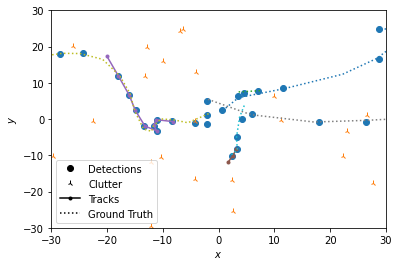

In [17]:
groundtruth = set()
detections = set()
tracks = set()
for time, ctracks in tracker:
    groundtruth.update(groundtruth_sim.groundtruth_paths)
    detections.update(detection_sim.detections)
    tracks.update(ctracks)

from stonesoup.metricgenerator.plotter import TwoDPlotter
plotter = TwoDPlotter(track_indices=[0, 2], gtruth_indices=[0, 2], detection_indices=[0, 1])
fig = plotter.plot_tracks_truth_detections(tracks, groundtruth, detections).value

ax = fig.axes[0]
ax.set_xlim([-30, 30])
_ = ax.set_ylim([-30, 30])